<a href="https://colab.research.google.com/github/KW-plato/CompCoxi/blob/main/notebooks/CompCoxi2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Create and upload master raw data file; Done.**


**Data Preprocessing and Descriptive Analysis as per reference paper: Done**

Next Step:
1. Run the statistical analysis as per refeence paper
2. Additional exploratory analysis on trajectory

**Reference:**
Calluso C, Saulin A, Baumgartner T
and Knoch D (2018) Distinct Patterns
of Cognitive Conflict Dynamics
in Promise Keepers and Promise
Breakers. Front. Psychol. 9:939.
doi: 10.3389/fpsyg.2018.00939


Set-up to access the datasets stored in GitHub repo

In [91]:
!git clone https://github.com/KW-plato/CompCoxi.git

fatal: destination path 'CompCoxi' already exists and is not an empty directory.


In [92]:
from ast import literal_eval
import glob
import matplotlib.pyplot as plt
import numpy as np
from os import listdir, path, makedirs
import pandas as pd
from scipy.interpolate import interp1d
import seaborn as sns

In [93]:
def standardize_x(x_list):
    start = x_list[0]
    end = x_list[-1]
    if end > start:
        return (x_list - start) / (end - start)
    else:
        return -1 * (x_list - start) / (end - start)

def standardize_y(y_list):
    start = y_list[0]
    end = y_list[-1]
    return 1.5 * (y_list - start) / (end - start)

def time_normalize(row): #can access by column names too since the whole row has been passed.Using number indexing to generalize
    f = interp1d(row[0], row[1])
    return f(row[2])

def flip_to_right_side(x_list): # y remains same. x gets flipped i.e negative x become positive, if end is on left i.e. (-1,1.5)
    if x_list[-1] < 0:
        return -1 * x_list
    else:
        return x_list


def make_figure(data,f_name,title_data): # plot one trajectory per trial i.e per row of the dataframe
    fig, ax = plt.subplots()
    ax.set_title("Participant: {}, {}".format(title_data[0], title_data[1]))
    for i in range(data.shape[0]):
        ax = plt.plot(data.iloc[i][0],data.iloc[i][1])
    plt.savefig(path.join(resultsrc,'Trajectories', f_name))
    plt.clf()
    plt.close(fig)

# **Preprocessing**

1.   Rescaled trajectories into a standard coordinate space.
2.   Time noormalization by re-sampling the time vector into
101 time-bins and then using linear interpolation to get the co-ordinates
3. Flip the endpoints of all trajectories flipped to the right



In [94]:
# Link to the folders, check/create results folder
participant_id = []
datasrc = "/content/CompCoxi/Data"
resultsrc = "/content/CompCoxi/Results"
try:
  makedirs(resultsrc)
except:
  pass

In [95]:
# Create a list of all the csv files in the Data folder
datafiles = glob.glob(path.join(datasrc, '*.csv'))


In [96]:
for idx,f in enumerate(datafiles):
    df = pd.read_csv(f)
    f = path.basename(f)
    #assign a participant code for each file, since raw data doesnt have this info. Save this for future reference
    participant_id.append({
        'file': f,
        'participant_id': idx + 1
    })
    f = f.rstrip('.csv')
    df = df[df['Condition'].isin(['Promise','NoTrust','Trust'])].reset_index()
    df = df[['Condition', 'PromiseStage', 'Stage','payoff','accuracy','init_time','response', 'rt','tTrajectory', 'time_experiment',
             'xTrajectory', 'yTrajectory']]


    # when reading a csv read_csv reads arrays/lists as a string.
    # so literal_eval them to get the array first and then convert the array to numpy arrays for future procecssing
    df['tTrajectory'] = df['tTrajectory'].apply(lambda x: np.array(literal_eval(x)))
    df['xTrajectory'] = df['xTrajectory'].apply(lambda x: np.array(literal_eval(x)))
    df['yTrajectory'] = df['yTrajectory'].apply(lambda x: np.array(literal_eval(x)))
    #make_figure(df[['xTrajectory','yTrajectory']], f + '_1.jpg',(idx + 1,'Raw Trajectory'))


    # regularize start and end of every trial. Start (0,0). End (-1,1.5) if x decreases i.e left movement  else (1,1.5)
    #df['xTrajectory'] = df['xTrajectory'].apply(lambda x: standardize_x(x))
    #df['yTrajectory'] = df['yTrajectory'].apply(lambda y: standardize_y(y))
    df['x_norm'] = df['xTrajectory'].apply(lambda x: standardize_x(x))
    df['y_norm'] = df['yTrajectory'].apply(lambda y: standardize_y(y))

    #normalize trajectory by mapping each trial trajectory into 101 evenly spaced time-bins
    df['t_norm'] = df['tTrajectory'].apply(lambda x: np.linspace(x.min(), x.max(),101))
    df['x_norm'] = df[['tTrajectory', 'x_norm', 't_norm']].apply(lambda x: time_normalize(x), axis=1)
    df['y_norm'] = df[['tTrajectory', 'y_norm', 't_norm']].apply(lambda x: time_normalize(x), axis=1)
    # axis=1 required in apply since by default it applies on a series containing rows of each column i.e. axis=0
    #make_figure(df[['x_norm','y_norm']], f + '_2.jpg',(idx + 1,'Normalized Trajectory'))

    # flip all trajectories to the right for comparison
    df['x_flip'] = df['x_norm'].apply(lambda x: flip_to_right_side(x))
    #make_figure(df[['x_flip', 'y_norm']], f + '_3.jpg',(idx + 1,'Flipped Trajectory'))


    # add the participant code to the file
    df['participant_id'] = idx + 1
    if idx == 0:
        combined_data = df[['participant_id','Condition','Stage','payoff','accuracy','init_time','time_experiment',
                    'rt','t_norm','x_norm', 'y_norm','x_flip','xTrajectory','yTrajectory']]
    else:
        combined_data = pd.concat([
            combined_data,
            df[['participant_id','Condition','Stage','payoff','accuracy','init_time','time_experiment',
                'rt','t_norm','x_norm', 'y_norm','x_flip','xTrajectory','yTrajectory']]
                ], ignore_index=True)


In [97]:
# save the data after preprocesing
#combined_data.to_csv(path.join(resultsrc,'Combined_data.csv'),index=False,header=True)
subject_list = pd.DataFrame(participant_id,columns=['file','participant_id'])
#subject_list.to_csv(path.join(resultsrc,'participant_ids.csv'),index=False,header=True)

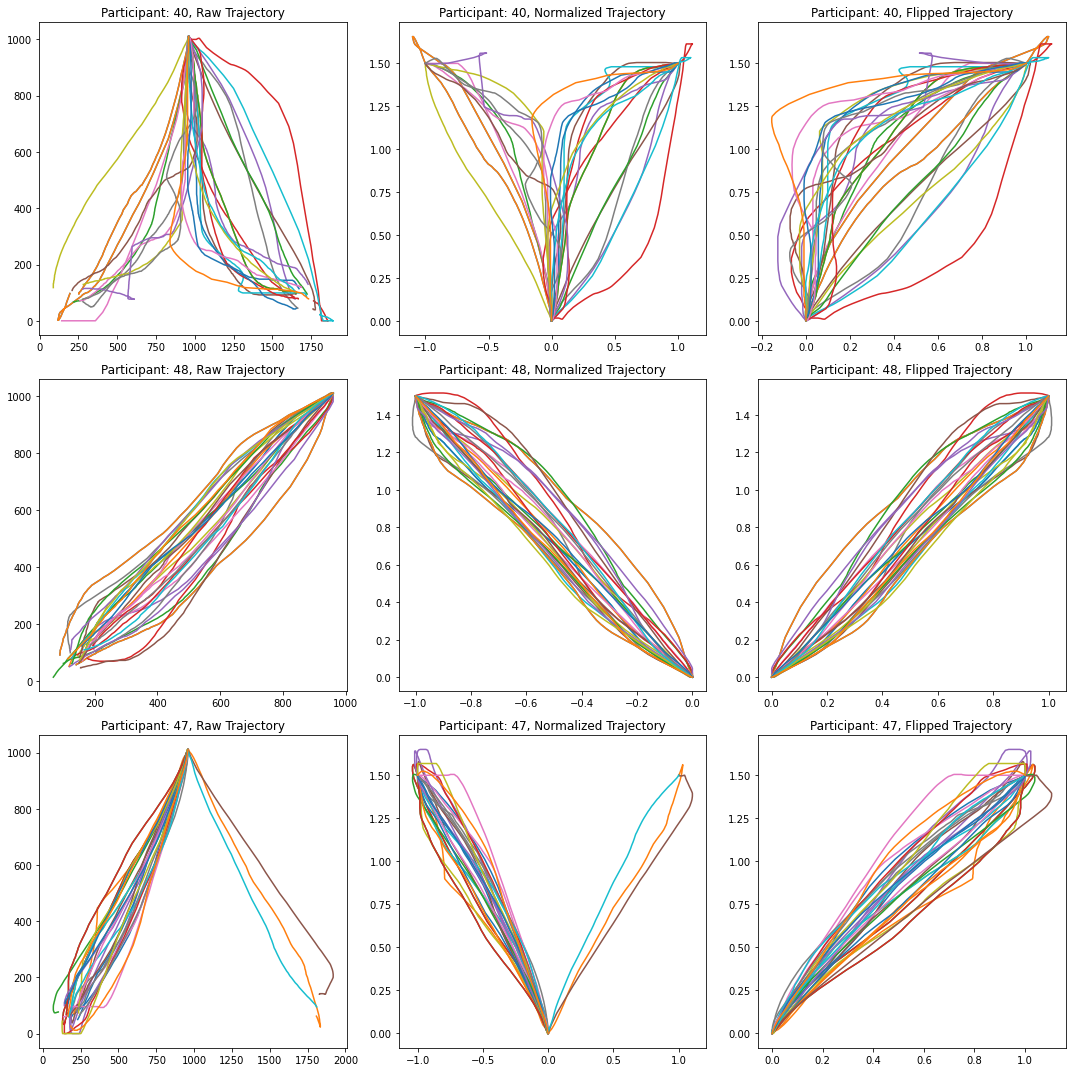

In [98]:
"""
For a random selection of subjects, plot their original mouse trajectories from raw data.
Also plot the coordinate and time normalized trajectories and the right flipped trajectory
"""

def draw_trajectories(data,axes):
  for i in range(data.shape[0]):
    axes.plot(data.iloc[i][0],data.iloc[i][1])


num_subjs = 3
pids = subject_list['participant_id'].sample(n=num_subjs)

fig, ax = plt.subplots(num_subjs, 3,figsize=(15,15))
for idx,subj in enumerate(pids):
  data = combined_data[combined_data['participant_id'] == subj]
  ax[idx,0].set_title("Participant: {}, Raw Trajectory".format(subj))
  draw_trajectories(data[['xTrajectory','yTrajectory']],ax[idx,0])
  ax[idx,1].set_title("Participant: {}, Normalized Trajectory".format(subj))
  draw_trajectories(data[['x_norm','y_norm']],ax[idx,1])
  ax[idx,2].set_title("Participant: {}, Flipped Trajectory".format(subj))
  draw_trajectories(data[['x_flip', 'y_norm']],ax[idx,2])

plt.tight_layout()
plt.show()


  

In [99]:
#drop unneccesary columns from combined data and handover to the analysis section
combined_data.drop(columns=['xTrajectory','yTrajectory'],axis=1,inplace=True)
print(combined_data.columns)

Index(['participant_id', 'Condition', 'Stage', 'payoff', 'accuracy',
       'init_time', 'time_experiment', 'rt', 't_norm', 'x_norm', 'y_norm',
       'x_flip'],
      dtype='object')


# **Analysis**



In [100]:
#ensure accuracy is numeric since it will be used in calculation
combined_data['accuracy'] = pd.to_numeric(combined_data['accuracy'])

In [101]:
"""
What was the promise made by the subject:
Available in the rows with the 'Promise' condition. 2 valid types 'sometimes' and 'always'.
Set 'promise' of all other rows i.e the Payback rows to 'na' at this stage
"""
conditions = [
    (combined_data['Condition'] == 'Promise') & (combined_data['accuracy'] == 0),
    (combined_data['Condition'] == 'Promise') & (combined_data['accuracy'] == 1),
    combined_data['Condition'] != 'Promise'
]
values = ['sometimes', 'always', 'na']
combined_data['promise'] = np.select(conditions, values)

In [102]:
"""
Tag 'promise' each Payback row with the promise made in the last Promise trial before that set of Payback trails.
For the 3 payback rows after every promise row the promise stays the same.
1. find the index of the promise rows and the promise value
2. list comprehension: select the promise value of a promise row and repeat the promise value for 4 successive rows starting from the first promise row
3. reassign this list to the promise column of the DF
"""
promises = combined_data[combined_data['Condition'] == 'Promise']['promise'].reset_index(level=0)
vals = [combined_data.iloc[i]['promise'] for i in promises['index'].to_list() for _ in range(4)]
combined_data['promise'] = vals

In [103]:
"""
For each trial tag the outcome. Valid only for Payback trials. 
Outcome is break if promise is broken and keep if promise is kept.
Promise trial has no outcome(will be set to 'na).
"""
payoff_condition = [(combined_data['Stage'] == 'Payback') & (combined_data['accuracy'] == 0),
                    (combined_data['Stage'] == 'Payback') & (combined_data['accuracy'] == 1),
                    (combined_data['Stage'] != 'Payback')
                    ]
condition_values = ['break', 'keep', 'na']
combined_data['outcome'] = np.select(payoff_condition, condition_values)

In [104]:
"""
The MD is the largest perpendicular deviation between the real trajectory and the theoretical trajectory (i.e., straight line connecting each trajectory’s start and endpoints) out of all
time steps.
Since we have 101 points on the trajectory already. We appromixate MD as the point whose perpendicular distance from the theoterical trajectory is maximum.
"""
def calculate_MaxDev(data):
  x = np.array([1,1.5]).reshape(2,1) #vector equiv. to the theretical trajectory
  projection_m = np.dot(x,x.T) / np.dot(x.T,x)
  points = np.stack((data[0],data[1]))
  perp = points - np.matmul(projection_m,points)
  #print(projection_m.shape, data.shape, perp.shape)
  return (np.linalg.norm(perp,axis=0).max())

combined_data['max_dev'] = combined_data[['x_flip','y_norm']].apply(lambda x:calculate_MaxDev(x),axis=1)


Total No. of participants in the experiment      : 48
No. of participants who only promsied 'always'   : 27 (56.25%)
No. of participants who also promised 'sometimes': 21 (43.75%)




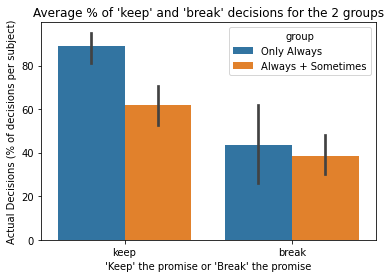

In [105]:
"""
Identify subjects who only promised 'always' and those who promsied both 'sometimes' and 'always'
"""
# keep only the data of payback trials and trust condition. Removed the notrusted trial since no investments made in these cases
filtered = combined_data[(combined_data['Condition'] == 'Trust') & 
                             (combined_data['Stage'] == 'Payback')]

subject_data = filtered.groupby(['participant_id'])['promise'].value_counts(normalize=True).reset_index(name='val')
always = subject_data[(subject_data['promise'] == 'always') & (subject_data['val'] == 1)]['participant_id'].unique()
sometimes = subject_data[~subject_data['participant_id'].isin(always)]['participant_id'].unique()
print("Total No. of participants in the experiment      : {:2d}".format(len(always)+len(sometimes)))
print("No. of participants who only promsied 'always'   : {:2d} ({:.2%})".format(len(always), len(always)/(len(always)+len(sometimes))))
print("No. of participants who also promised 'sometimes': {:2d} ({:.2%})".format(len(sometimes), len(sometimes)/(len(always)+len(sometimes))))
print("\n")

"""
Average percentages of keep (green bars) and break (red bars) decisions as a function of promise decisions (“ALWAYS” vs. “SOMETIMES”).
"""
behavior = filtered.groupby(['participant_id'])['outcome'].value_counts(normalize=True).reset_index(name='val')
behavior['val'] = behavior['val'] * 100
behavior['group'] = 'Only Always'
behavior.loc[behavior['participant_id'].isin(sometimes),'group'] = 'Always + Sometimes'
fig, ax = plt.subplots()
b = sns.barplot(data=behavior,x=behavior['outcome'], y=behavior['val'],hue=behavior['group'],ax=ax)
b.set(xlabel = "'Keep' the promise or 'Break' the promise",
      ylabel = "Actual Decisions (% of decisions per subject)",
      title= "Average % of 'keep' and 'break' decisions for the 2 groups" )
plt.show()


In [106]:
# segregate the two sets of trials..ones where outcome is keep and the other where outcome is break
# difference with the main paper: removed the not trusted trial since then no investment has been made anyway
keep_trials = combined_data[
                            (combined_data['Condition'] == 'Trust') & 
                            (combined_data['Stage'] == 'Payback') & 
                            (combined_data['promise'] == 'always') & 
                            (combined_data['outcome'] == 'keep')
                            ]
break_trials = combined_data[
                             (combined_data['Condition'] == 'Trust') & 
                             (combined_data['Stage'] == 'Payback') & 
                             (combined_data['promise'] == 'always') & 
                             (combined_data['outcome'] == 'break')
                             ]


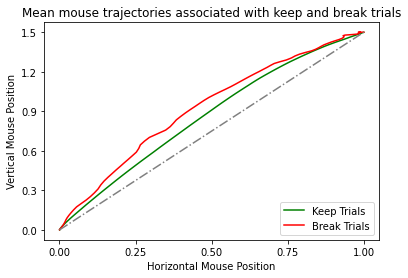

In [107]:
"""
compare the average trajectory of keep and break situations
"""
xsk = keep_trials['x_flip'].sum() / keep_trials.shape[0]
ysk = keep_trials['y_norm'].sum() / keep_trials.shape[0]

xsb = break_trials['x_flip'].sum() / break_trials.shape[0]
ysb = break_trials['y_norm'].sum() / break_trials.shape[0]

fig, ax = plt.subplots()
ax.set_title("Mean mouse trajectories associated with keep and break trials")
ax.set_ylabel('Vertical Mouse Position')
ax.set_yticks(np.linspace(0,1.5,6))
ax.set_xlabel('Horizontal Mouse Position')
ax.set_xticks(np.linspace(0,1.0,5))
ax = plt.plot(xsk,ysk,color='green',label='Keep Trials')
ax = plt.plot(xsb,ysb,color='red',label='Break Trials')
ax = plt.plot([0,1],[0,1.5], color='gray', linestyle='-.')
plt.legend(loc='lower right')
plt.show()

In [112]:
"""
Promise Keepers   : Said 'Always' and 'kept' always
Promise Breakeers : Said 'Always' and sometimes 'break' 
"""
behavior = filtered.groupby(['participant_id','promise'])['outcome'].value_counts(normalize=True).reset_index(name='val')
keepers = behavior[(behavior['promise'] == 'always') & 
                   (behavior['outcome'] == 'keep') &
                   (behavior['val'] == 1)]['participant_id'].unique()
breakers = behavior[~behavior['participant_id'].isin(keepers)]['participant_id'].unique()


In [109]:
"""
Segreate Promise Keepers and Promise Breakers
Visualize MD(maximum deviation) of each group and compare
"""

tmpdf = filtered[['participant_id','outcome','max_dev','x_flip','y_norm']]
tmpdf['group'] = np.select([tmpdf['participant_id'].isin(keepers),tmpdf['participant_id'].isin(breakers)],['keeper','breaker'])
keeper_keeptrials = tmpdf[(tmpdf['group'] == 'keeper') & (tmpdf['outcome'] == 'keep')]
keeper_breaktrials = tmpdf[(tmpdf['group'] == 'keeper') & (tmpdf['outcome'] == 'break')]
breaker_keeptrials = tmpdf[(tmpdf['group'] == 'breaker') & (tmpdf['outcome'] == 'keep')]
breaker_breaktrials = tmpdf[(tmpdf['group'] == 'breaker') & (tmpdf['outcome'] == 'break')]
keeper_keeptrials_xs = keeper_keeptrials['x_flip'].sum()/keeper_keeptrials.shape[0]
keeper_keeptrials_ys = keeper_keeptrials['y_norm'].sum()/keeper_keeptrials.shape[0]
keeper_breaktrials_xs = keeper_breaktrials['x_flip'].sum()/keeper_breaktrials.shape[0]
keeper_breaktrials_ys = keeper_breaktrials['y_norm'].sum()/keeper_breaktrials.shape[0]
breaker_keeptrials_xs = breaker_keeptrials['x_flip'].sum()/breaker_keeptrials.shape[0]
breaker_keeptrials_ys = breaker_keeptrials['y_norm'].sum()/breaker_keeptrials.shape[0]
breaker_breaktrials_xs = breaker_breaktrials['x_flip'].sum()/breaker_breaktrials.shape[0]
breaker_breaktrials_ys = breaker_breaktrials['y_norm'].sum()/breaker_breaktrials.shape[0]



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


Promise Keepers  - When 'Always' then only 'kept'  : 22 (45.83%)
Promise Breakers - When 'Always' then also 'break' : 26 (54.17%)




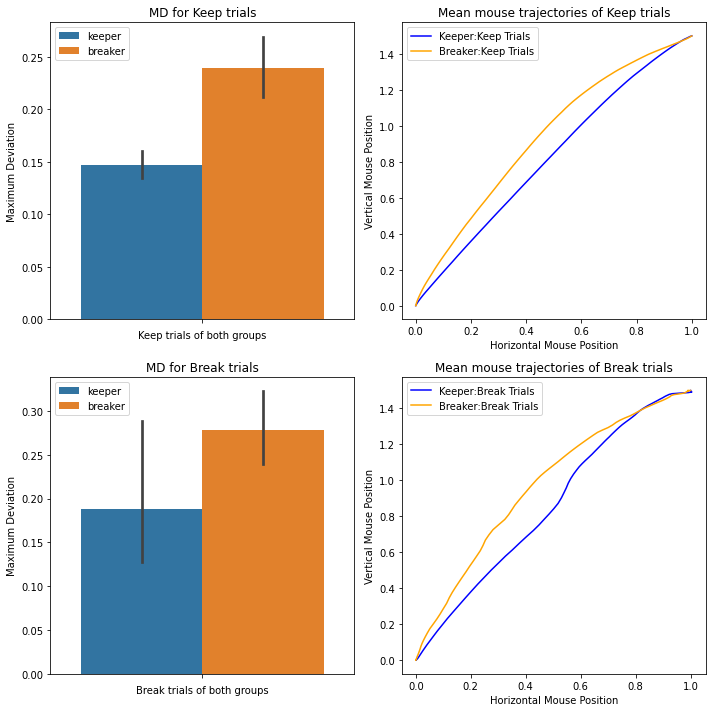

In [111]:
print("Promise Keepers  - When 'Always' then only 'kept'  : {:2d} ({:.2%})".format(len(keepers), len(keepers)/(len(keepers)+len(breakers))))
print("Promise Breakers - When 'Always' then also 'break' : {:2d} ({:.2%})".format(len(breakers), len(breakers)/(len(keepers)+len(breakers))))
print("\n")

fig, ax = plt.subplots(2,2,figsize=(10,10))

b1 = sns.barplot(x='outcome',y='max_dev',hue='group',data=tmpdf[tmpdf['outcome']=='keep'],ax=ax[0,0])
b1.set(xlabel='Keep trials of both groups', xticklabels=[], ylabel='Maximum Deviation',title='MD for Keep trials')
ax[0,0].legend(loc='upper left')
b2 = sns.barplot(x='outcome',y='max_dev',hue='group',data=tmpdf[tmpdf['outcome']=='break'],ax=ax[1,0])
b2.set(xlabel='Break trials of both groups', xticklabels=[],ylabel='Maximum Deviation',title='MD for Break trials')
ax[1,0].legend(loc='upper left')
ax[0,1].plot(keeper_keeptrials_xs,keeper_keeptrials_ys,color='blue',label='Keeper:Keep Trials')
ax[0,1].plot(breaker_keeptrials_xs,breaker_keeptrials_ys,color='orange',label='Breaker:Keep Trials')
ax[0,1].legend(loc='upper left')
ax[0,1].set_title('Mean mouse trajectories of Keep trials')
ax[0,1].set_xlabel('Horizontal Mouse Position')
ax[0,1].set_ylabel('Vertical Mouse Position')
ax[1,1].plot(keeper_breaktrials_xs,keeper_breaktrials_ys,color='blue',label='Keeper:Break Trials')
ax[1,1].plot(breaker_breaktrials_xs,breaker_breaktrials_ys,color='orange',label='Breaker:Break Trials')
ax[1,1].legend(loc='upper left')
ax[1,1].set_title('Mean mouse trajectories of Break trials')
ax[1,1].set_xlabel('Horizontal Mouse Position')
ax[1,1].set_ylabel('Vertical Mouse Position')

plt.tight_layout()
plt.show()